# 1 Import Libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from joblib import dump

%matplotlib inline

# 2 Read Dataset

In [2]:
df = pd.read_csv('heart.csv')
df 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# 3 Dataset Overview

In [3]:
# Dataset Basic Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
# Dataset Basic Information
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

features_to_convert = [feature for feature in df.columns if feature not in continuous_features]
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [5]:
# Summary Statistics for Numerical Variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [6]:
# Summary Statistics for Categorical  Variables
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


# 4 EDA

## 4.1 Univariate Analysis

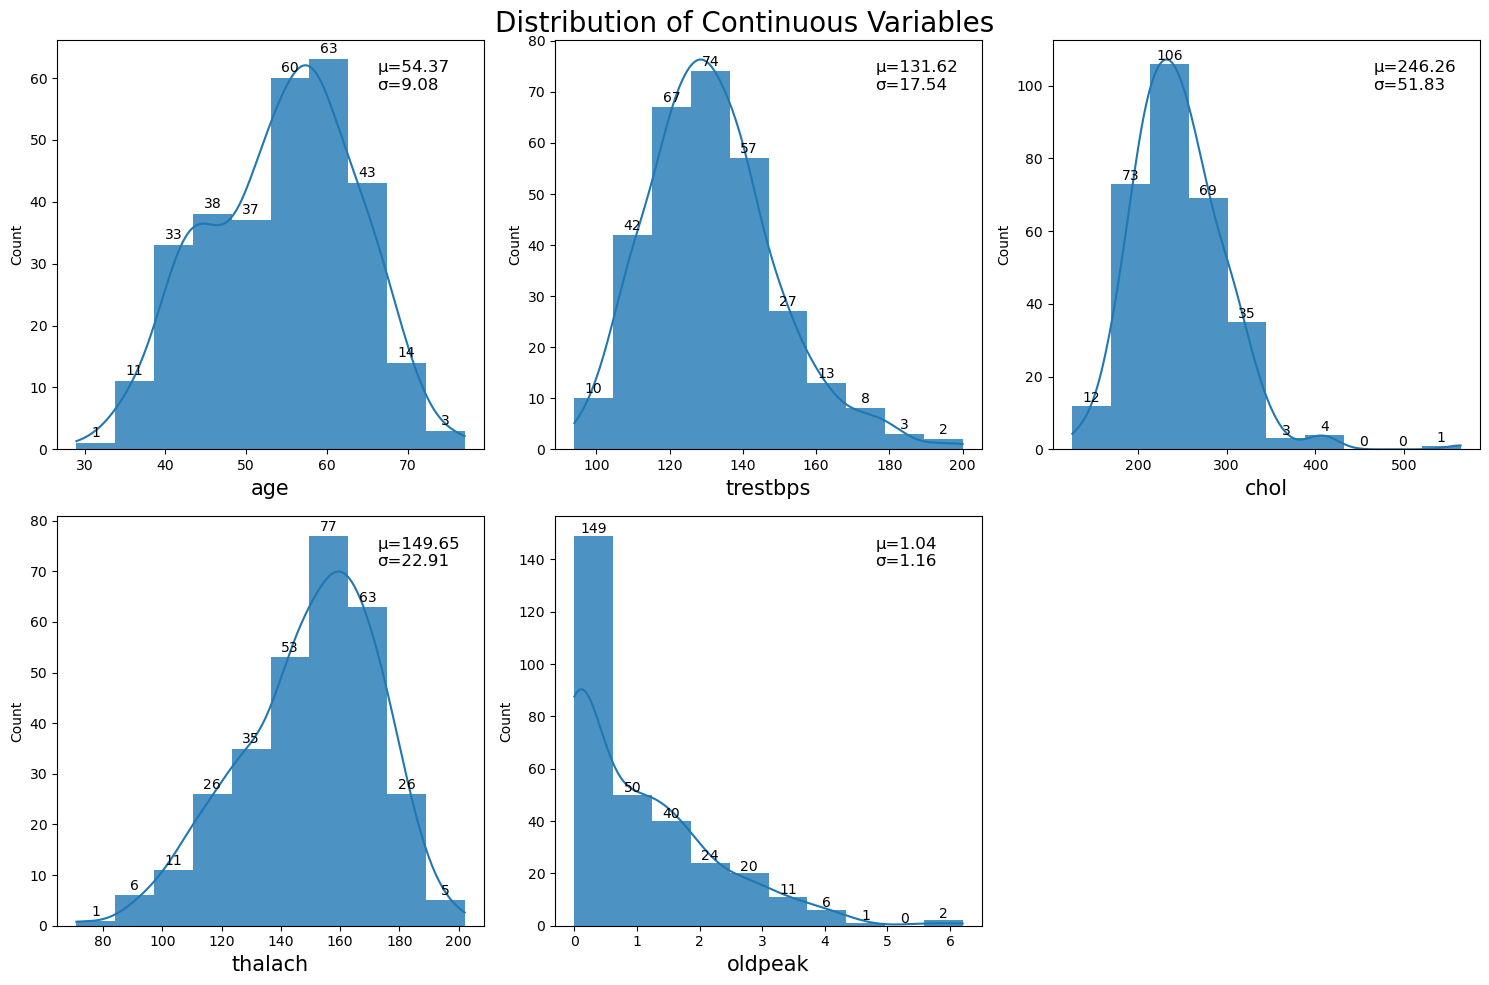

In [7]:
# Numerical Variables Univariate Analysis

df_continuous = df[continuous_features]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, col in enumerate(df_continuous.columns):
    x, y = i//3, i%3
    
    values, bin_edges = np.histogram(df_continuous[col])
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y], edgecolor='none', alpha=0.8)
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count')
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height() + 1), ha='center')
    
    textstr = f'μ={df_continuous[col].mean():.2f}\nσ={df_continuous[col].std():.2f}'
    ax[x, y].text(0.75, 0.95, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top')

ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

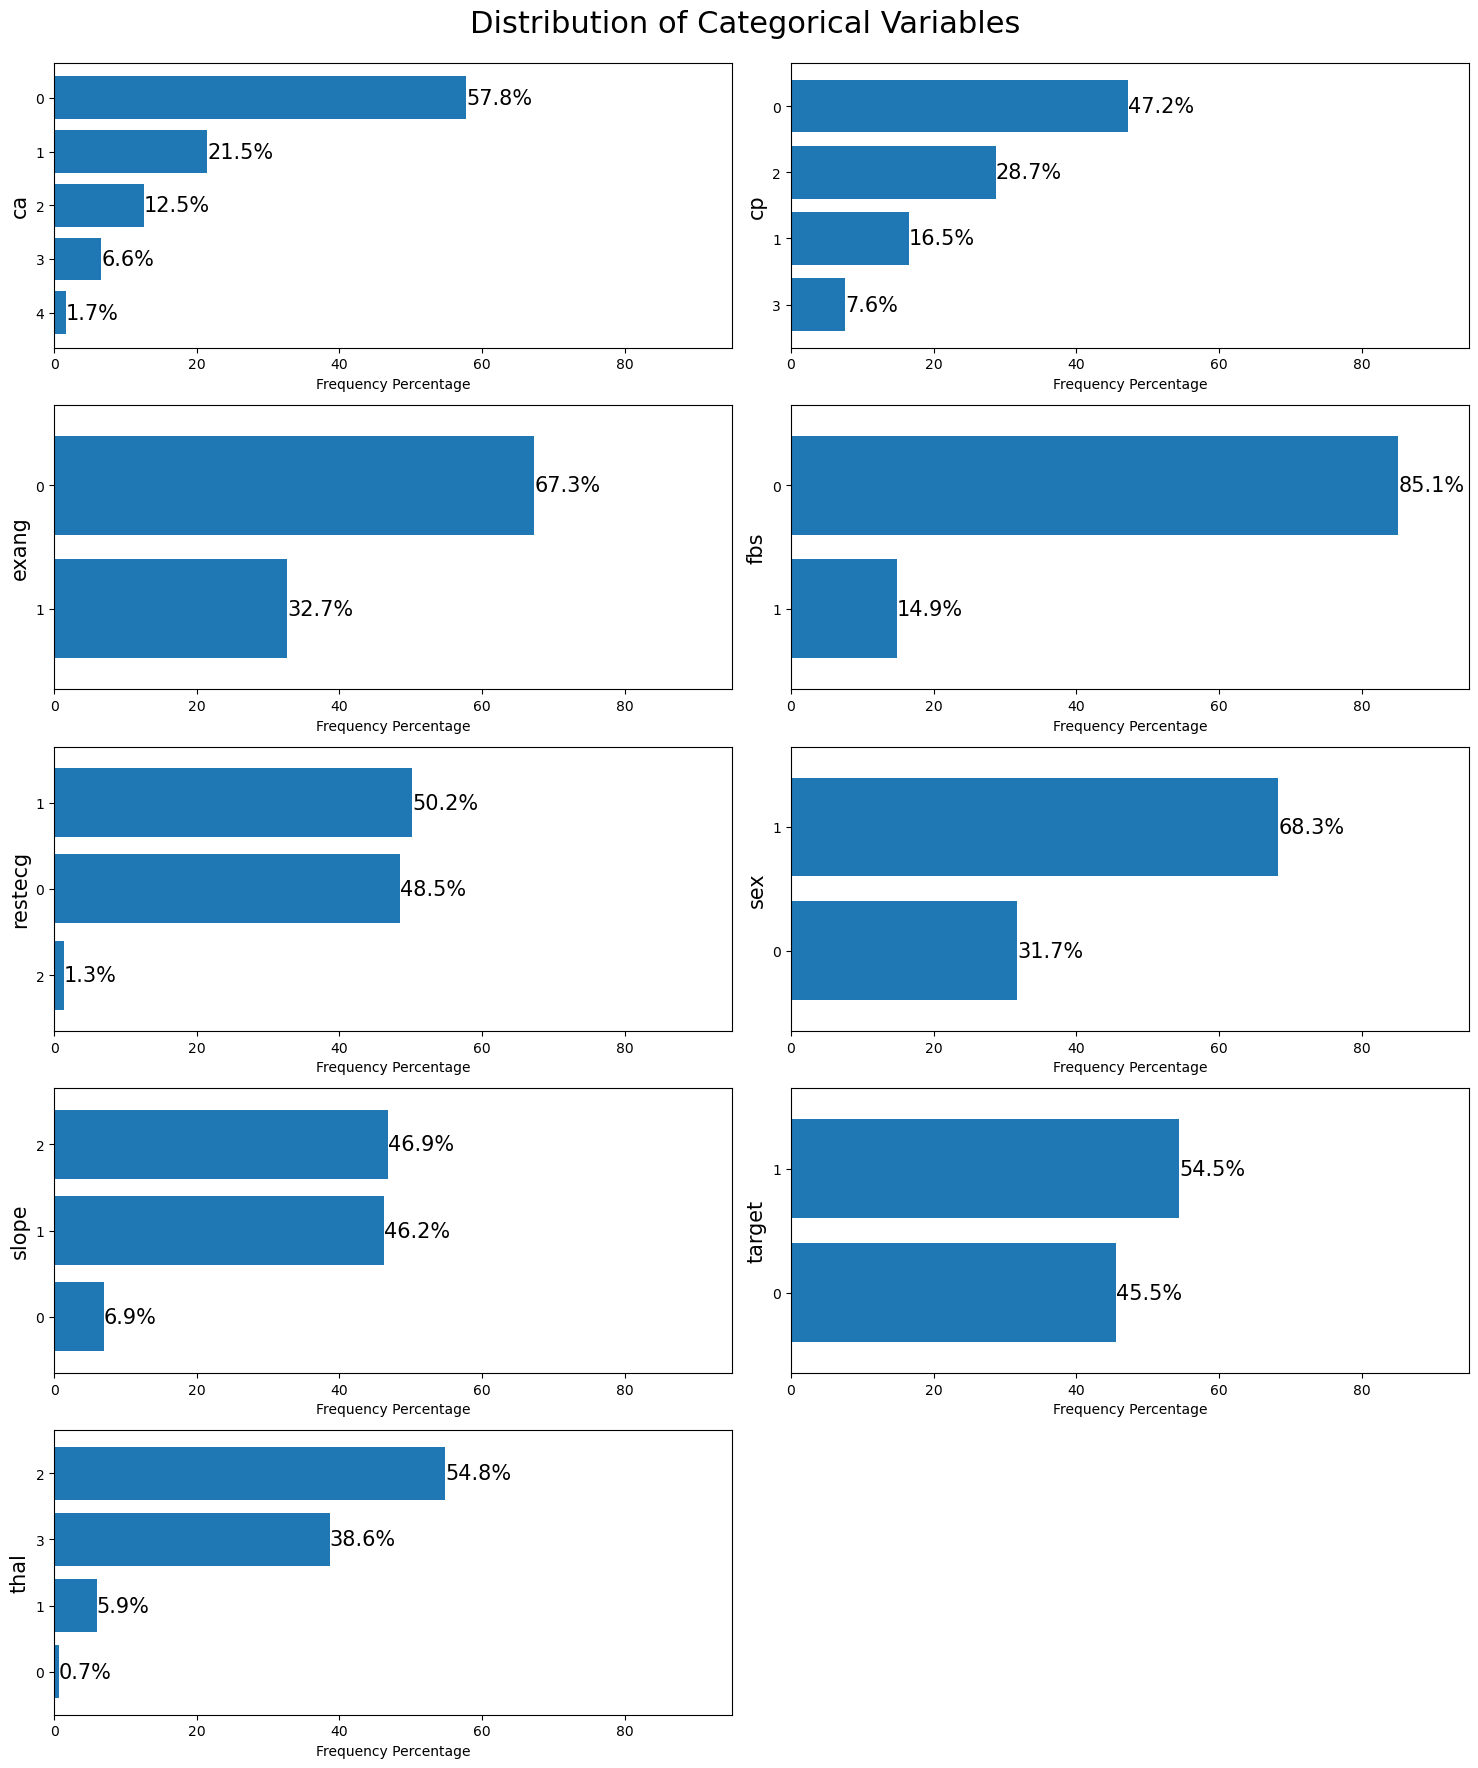

In [8]:
# Categorical Variables Univariate Analysis

categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

for i, col in enumerate(categorical_features):
    row_idx, col_idx = i//2, i%2
    
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    
    value_counts.plot(kind='barh', ax=ax[row_idx, col_idx], width=0.8)
    
    for index, value in enumerate(value_counts):
        ax[row_idx, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, va='center')
    
    ax[row_idx, col_idx].set_xlim([0, 95])
    ax[row_idx, col_idx].set_xlabel('Frequency Percentage')
    ax[row_idx, col_idx].set_ylabel(f'{col}', fontsize=15)

ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## 4.2 Bivariate Analysis

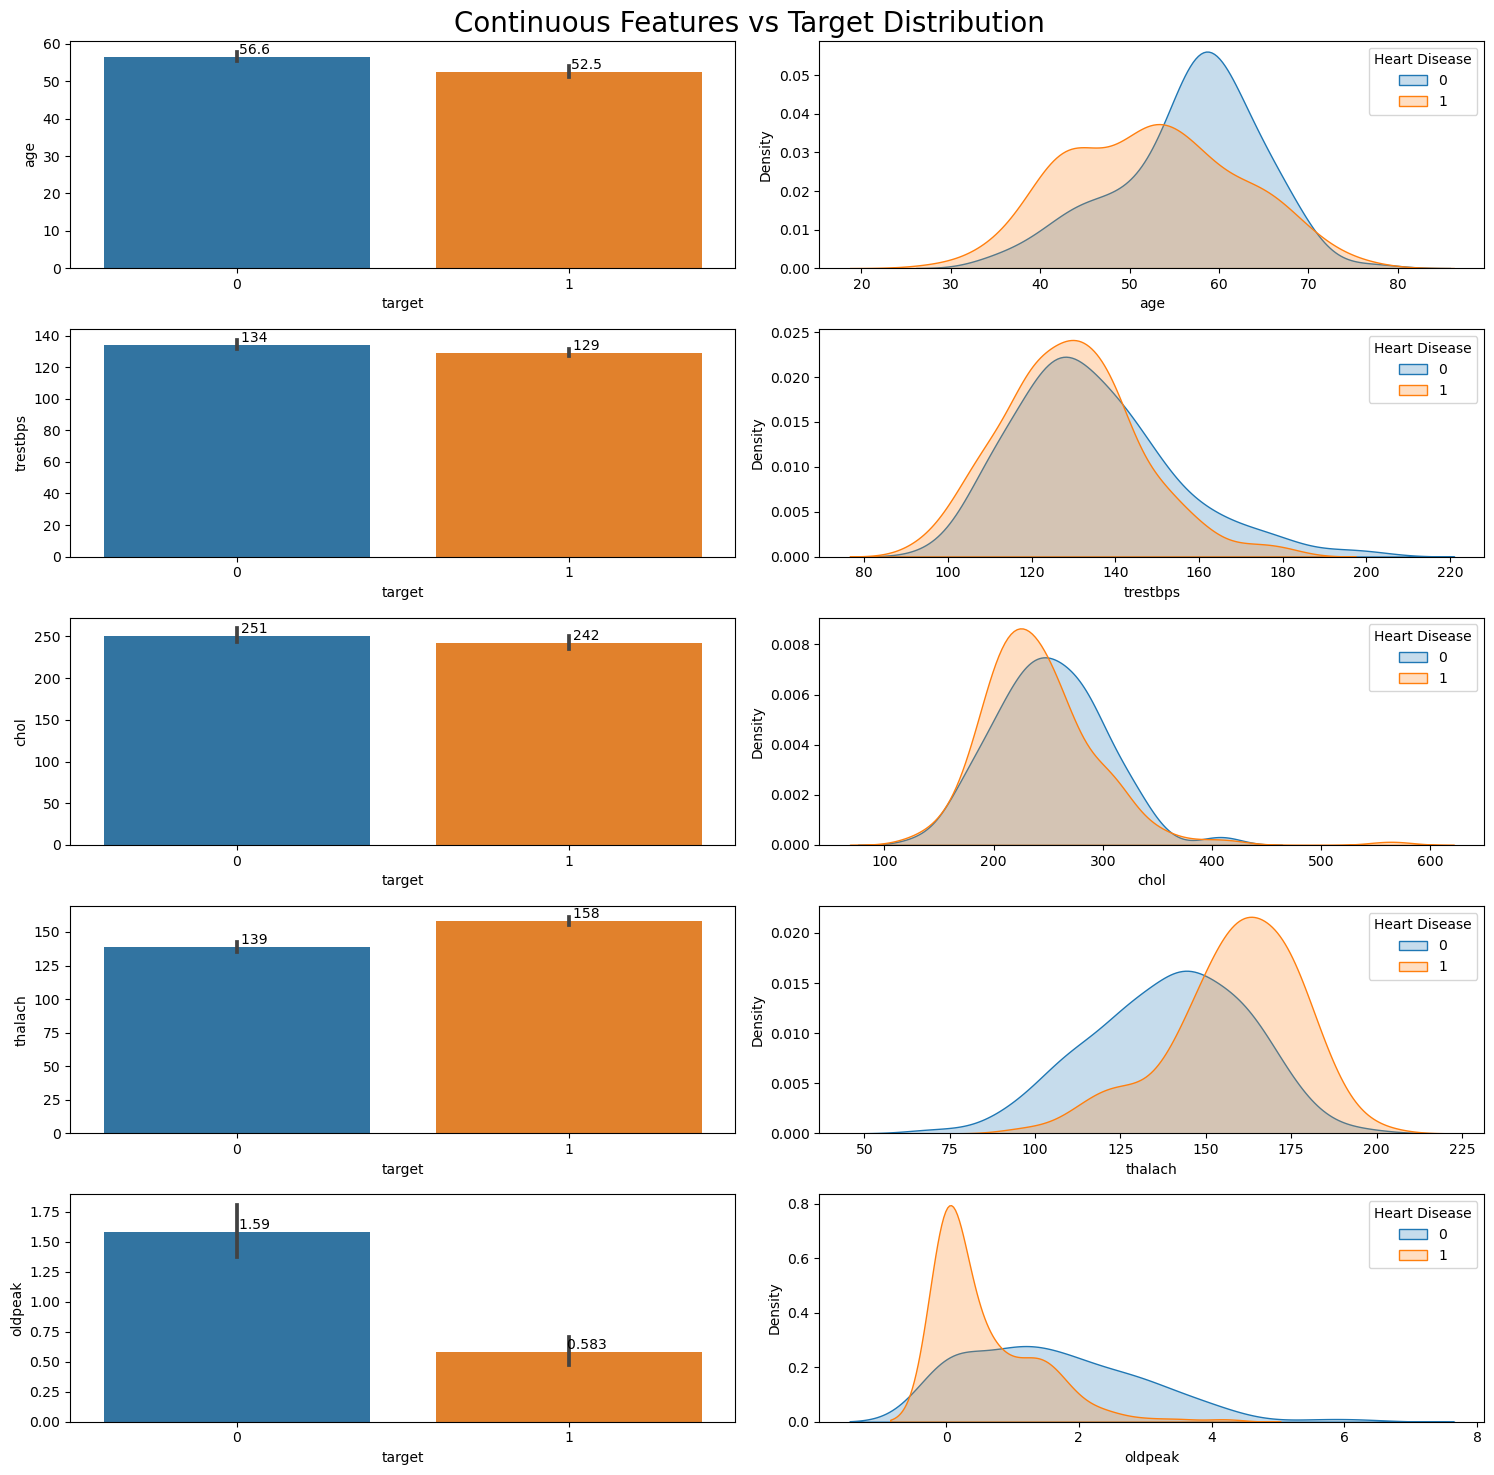

In [9]:
# Numerical Features vs Target

fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15))

for i, col in enumerate(continuous_features):
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])
    
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, ax=ax[i,1], label='1')
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    
    for cont in graph.containers:
        graph.bar_label(cont, fmt='        %.3g')
        
plt.suptitle('Continuous Features vs Target Distribution', fontsize=20)
plt.tight_layout()                     
plt.show()

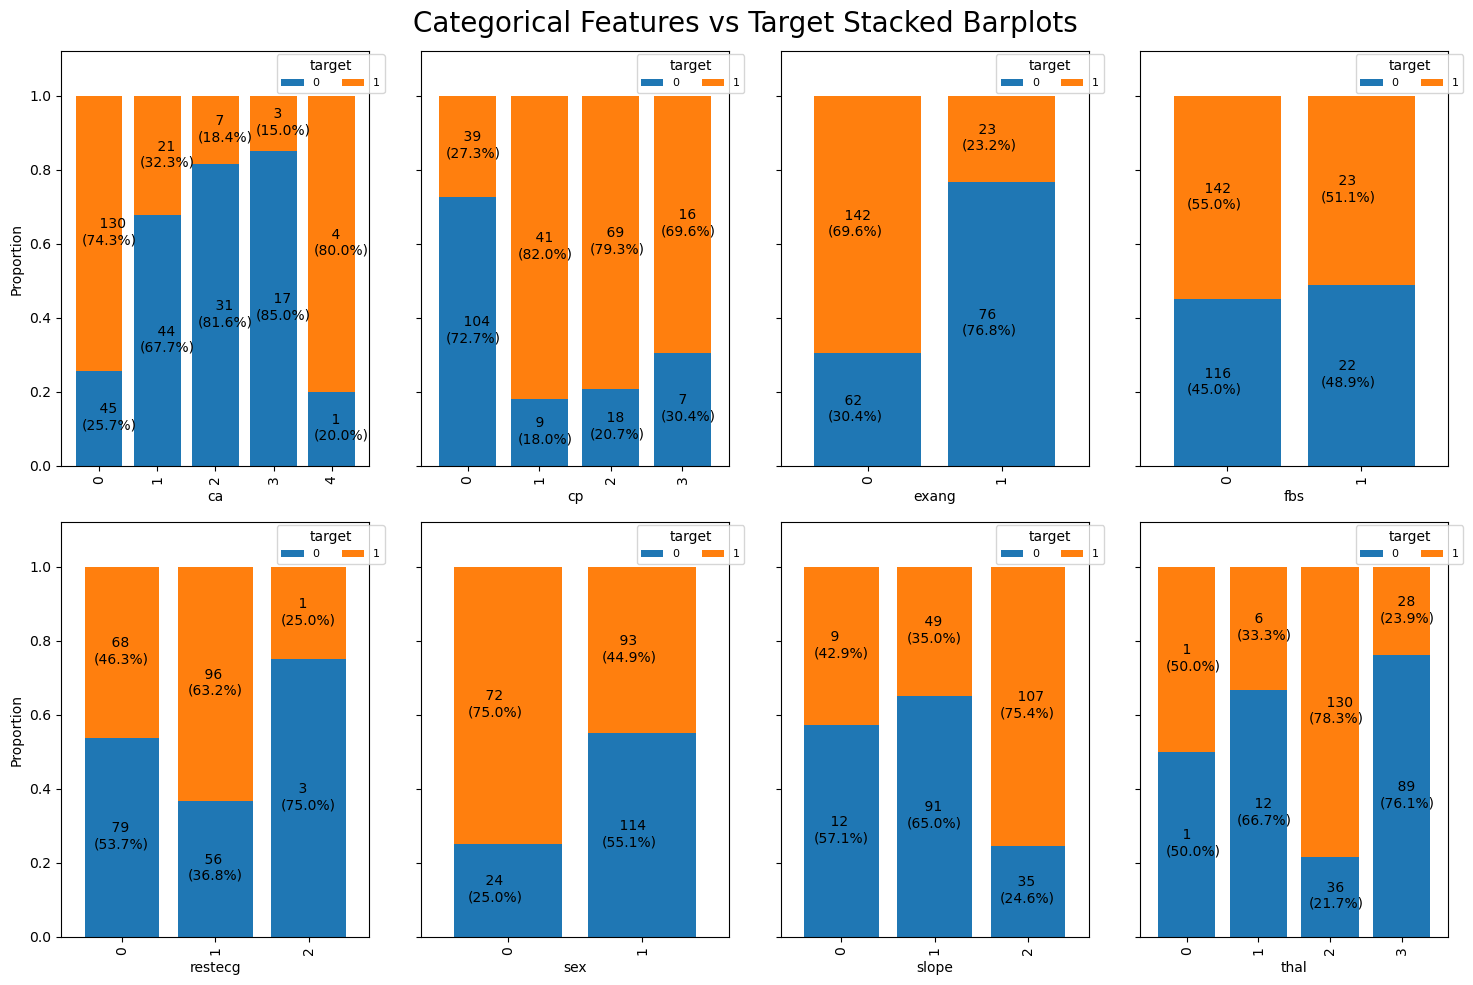

In [10]:
# Categorical Features vs Target

categorical_features = [feature for feature in categorical_features if feature != 'target']

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')
    
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, ylabel='Proportion', sharey=True)
    
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val], cross_tab.loc[val], cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03, s=f'    {count}\n({np.round(proportion * 100, 1)}%)')
    
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    ax[x,y].set_ylim([0,1.12])
    
            
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=20)
plt.tight_layout()                     
plt.show()

# 5 Data Preprocessing

## 5.1 Irrelevant Features Removal

In [11]:
# All features in the dataset appear to be relevant based on EDA.

## 5.2 Missing Value Treatment

In [12]:
df.isnull().sum().sum()

0

## 5.3 Outlier Treatment

In [13]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1

outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()
outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

## 5.4 Categorical Features Encoding

In [14]:
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes

age            int64
sex            int32
trestbps       int64
chol           int64
fbs            int32
thalach        int64
exang          int32
oldpeak      float64
slope          int32
ca             int32
target         int32
cp_1            bool
cp_2            bool
cp_3            bool
restecg_1       bool
restecg_2       bool
thal_1          bool
thal_2          bool
thal_3          bool
dtype: object

In [15]:
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,False,False,True,False,False,True,False,False
1,37,1,130,250,0,187,0,3.5,0,0,1,False,True,False,True,False,False,True,False
2,41,0,130,204,0,172,0,1.4,2,0,1,True,False,False,False,False,False,True,False
3,56,1,120,236,0,178,0,0.8,2,0,1,True,False,False,True,False,False,True,False
4,57,0,120,354,0,163,1,0.6,2,0,1,False,False,False,True,False,False,True,False


## 5.5 Feature Scaling

In [16]:
# We will handle feature scaling later using pipelines because we intent to use a mix of models and not all algorithms require scaled data.

## 5.6 Transforming Skewed Features

In [17]:
X = df_encoded.drop('target', axis=1)
y = df_encoded['target'] 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [19]:
X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001

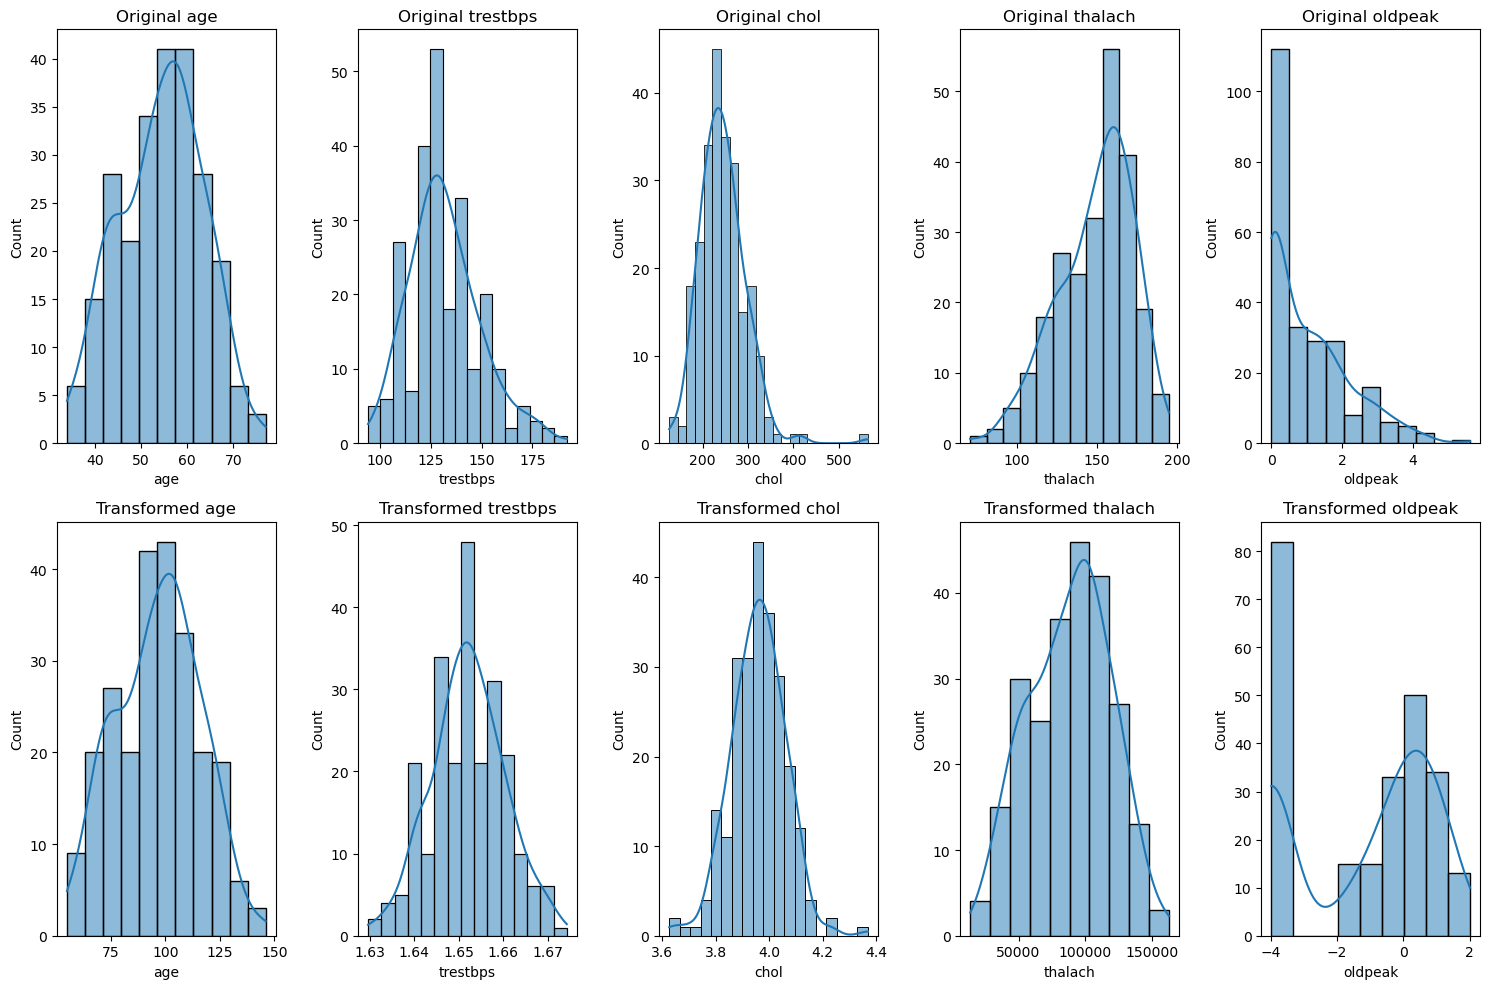

In [20]:
fig, ax = plt.subplots(2, 5, figsize=(15,10))

for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0,i]).set_title(f'Original {col}')
    

lambdas = {}
for i, col in enumerate(continuous_features):
    if X_train[col].min() > 0:
        X_train[col], lambdas[col] = boxcox(X_train[col])
        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col])
        sns.histplot(X_train[col], kde=True, ax=ax[1,i]).set_title(f'Transformed {col}')
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1,i]).set_title(f'{col} (Not Transformed)')

fig.tight_layout()
plt.show()

In [21]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
269,99.775303,1,1.652121,4.044510,1,34193.175862,1,0.490856,0,0,False,False,False,False,False,False,False,True
191,104.060224,1,1.651136,3.909224,0,61564.541974,1,0.846853,1,3,False,False,False,False,False,False,False,True
15,87.096543,0,1.646937,3.916242,0,97354.732537,0,0.490856,1,0,False,True,False,True,False,False,True,False
224,95.519131,1,1.641028,3.960430,0,55975.802227,1,1.130195,1,1,False,False,False,True,False,False,False,True
250,89.190680,1,1.656716,4.069854,0,51729.405015,1,1.634849,1,3,False,False,False,True,False,False,False,True


# 6 Model Building

In [22]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    clf_grid.fit(X_train, y_train)
    
    return clf_grid.best_estimator_, clf_grid.best_params_

In [23]:
def evaluate_model(model, X_test, y_test, model_name):
    
    y_pred = model.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }
    
    df = pd.DataFrame(metrics, index=[model_name]).round(2)
    
    return df

## 6.1 Decision Tree Model Building

In [24]:
# DT Base Model Definition

dt_base = DecisionTreeClassifier(random_state=0)

In [25]:
# DT Hyperparameter Tuning

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [26]:
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [27]:
# DT Model Evaluation

print(classification_report(y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       110
           1       0.78      0.77      0.78       132

    accuracy                           0.76       242
   macro avg       0.76      0.76      0.76       242
weighted avg       0.76      0.76      0.76       242



In [28]:
print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        28
           1       0.78      0.85      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



In [29]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'DT')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.8,0.78,0.71,0.85,0.75,0.81,0.79,0.78,0.78,0.79


## 6.2 Random Forest Model Building

In [30]:
# RF Base Model Definition

rf_base = RandomForestClassifier(random_state=0)

In [31]:
# RF Hyperparameter Tuning

param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

In [32]:
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)

print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 30}


In [33]:
# RF Model Evaluation

print(classification_report(y_train, best_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       110
           1       0.83      0.87      0.85       132

    accuracy                           0.83       242
   macro avg       0.83      0.83      0.83       242
weighted avg       0.83      0.83      0.83       242



In [34]:
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



In [35]:
rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'RF')
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84


## 6.3 KNN Model Building

In [36]:
# KNN Base Model Definition

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [37]:
# KNN Hyperparameter Tuning

knn_param_grid = {
    'knn__n_neighbors': list(range(1, 12)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

In [38]:
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, y_train)

print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

KNN Optimal Hyperparameters: 
 {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}


In [39]:
# KNN Model Evaluation

print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       110
           1       0.83      0.83      0.83       132

    accuracy                           0.81       242
   macro avg       0.81      0.81      0.81       242
weighted avg       0.81      0.81      0.81       242



In [40]:
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



In [41]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'KNN')
knn_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
KNN,0.82,0.85,0.82,0.85,0.82,0.85,0.83,0.83,0.83,0.84


## 6.4 SVM Model Building

In [42]:
# SVM Base Model Definition

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True)) 
])

In [43]:
# SVM Hyperparameter Tuning

param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],  
    'svm__degree': [2, 3, 4]
}

In [44]:
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, y_train)

print('SVM Optimal Hyperparameters: \n', best_svm_hyperparams)

SVM Optimal Hyperparameters: 
 {'svm__C': 0.0011, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}


In [45]:
# SVM Model Evaluation

print(classification_report(y_train, best_svm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.54      0.68       110
           1       0.71      0.96      0.82       132

    accuracy                           0.77       242
   macro avg       0.82      0.75      0.75       242
weighted avg       0.81      0.77      0.76       242



In [46]:
print(classification_report(y_test, best_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.57      0.71        28
           1       0.73      0.97      0.83        33

    accuracy                           0.79        61
   macro avg       0.83      0.77      0.77        61
weighted avg       0.83      0.79      0.78        61



In [47]:
svm_evaluation = evaluate_model(best_svm, X_test, y_test, 'SVM')
svm_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.94,0.73,0.57,0.97,0.71,0.83,0.83,0.77,0.77,0.79


# 7 Conclusion

In [48]:
all_evaluations = [dt_evaluation, rf_evaluation, knn_evaluation, svm_evaluation]
results = pd.concat(all_evaluations)

results = results.sort_values(by='recall_1', ascending=False).round(2)
results

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.94,0.73,0.57,0.97,0.71,0.83,0.83,0.77,0.77,0.79
RF,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84
DT,0.80,0.78,0.71,0.85,0.75,0.81,0.79,0.78,0.78,0.79
KNN,0.82,0.85,0.82,0.85,0.82,0.85,0.83,0.83,0.83,0.84


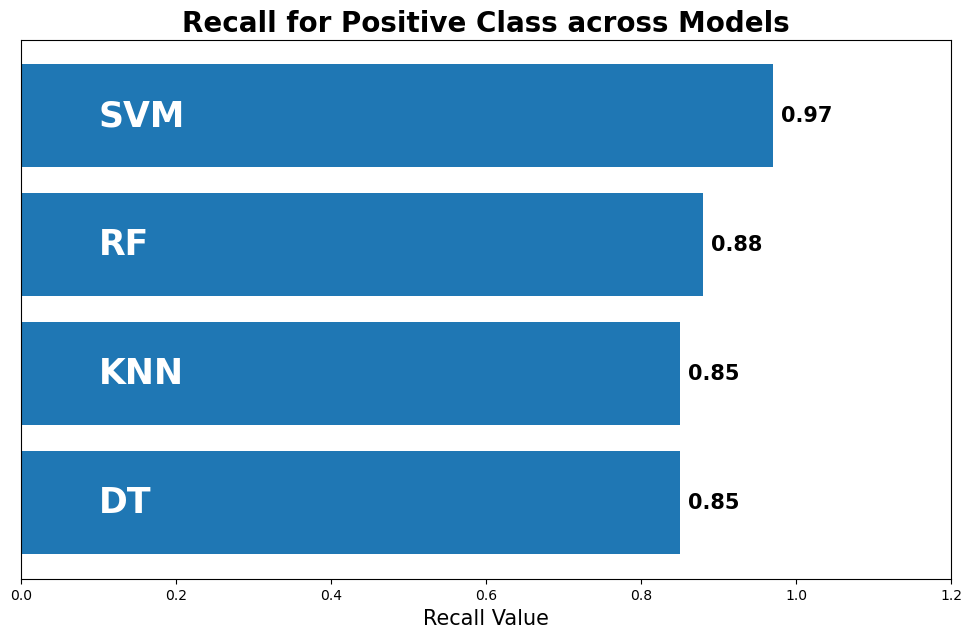

In [49]:
results.sort_values(by='recall_1', ascending=True, inplace=True)
recall_1_scores = results['recall_1']

fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(results.index, recall_1_scores)

for i, (value, name) in enumerate(zip(recall_1_scores, results.index)):
    ax.text(value + 0.01, i, f"{value:.2f}", ha='left', va='center', fontweight='bold', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=25)

ax.set_yticks([])
ax.set_xlim([0, 1.2])

plt.title("Recall for Positive Class across Models", fontweight='bold', fontsize=20)
plt.xlabel('Recall Value', fontsize=15)
plt.show()

In [50]:
# Model Saving
print(lambdas)

with open("svm.pkl", "wb") as f:
    dump(best_svm, f, protocol=5)

{'age': 1.1884623210915386, 'trestbps': -0.566961719937906, 'chol': -0.12552647234590764, 'thalach': 2.4454557922261086, 'oldpeak': 0.17759774936241574}
